In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error

import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

### 1. Import raw data

The raw data we import here assumes that the patient data has already been joined with other variables and aggregated at zipcode-timeperiod level. Each observation describes ER visits for a specific zip code, over a period of time. 

Dummy data below assumes "period of time" = 12 months. We should probably try looking at 6M and 12M periods.

In [2]:
#1a. Define columns 

#TBD: do we want to filter for age.
#TBD: unrelated side note - should we have taken elevation into account

columns = [
    ### time and place descriptors (potentially also background variables)
    'period_start', #TBD: to decide what lookback period makes the most sense. 6M? 1Y?
    'period_end', 
    'zip_code',
    
    ### response variables (TBD: to confirm that we would only want to count unique visits)
    'num_visits_total_mental', 
    'num_visits_depression',
    'num_visits_ptsd', #TBD:...non-exhaustive. make sure we include all relevant codes.
    
    ### explanatory variables (we'll probably only use one or two of these)
    'downwind', #this is the treatment field in the instrument file
    'months_downwind_from_fire',  #would have to be ordinal variable. Or could be downwind_1, downwind_2,downwind_n.. where n is the month in the period
    'avg_pm25_exposure',
    'months_over_pm25_threshold', #TBD: what is the "unsafe" threshold?
    'avg_dist_to_nearest_fire', #I don't think we have this data, just listing here first in case.would have to be ordinal variable
    
    ### fire-related background variables
    'avg_temperature', #might need to 
    'days_of_rain', #I don't think we have this data, just listing here first in case.
    
    ### zip code-related background variables
    #TBD: should we be defining demographics more granularly? (e.g. pct_male_asian_child) 
    #     to consult subject matter experts or EDA of patient data.
    'zip_code_population', 
    'zip_code_avg_elevation',
    'zip_code_median_income', #TBD: can debate if we want to use average or median income. Use EDA to decide
    'pct_ethnic_group_1', #we'll have many of these - one for each ethnic group
    'pct_age_group_1', #we'll have many of these - one for each age group
    'pct_male', 
    'pct_female',    
]

In [3]:
#1b. Generate dummy values

period_start                   = ['1991-01'] *10 + ['1992-01']*10
period_end                     = ['1992-01'] *10 + ['1993-01']*10
zip_code                       = [12345] * 5 + [67890] * 5 + [12345] * 5 + [67890] * 5 
num_visits_total_mental        = [10] * 20
num_visits_depression          = [3] * 20
num_visits_ptsd                = [7] * 20
downwind                       = [1] * 5  + [0] * 5 + [0] * 5 + [1] * 5 
months_downwind_from_fire      = [12] * 5 + [0] * 5 + [0] * 5 + [6] * 5 
avg_pm25_exposure              = [123.5] * 5 + [34.4] * 5 + [40.1] * 5 + [99.3] * 5 
months_over_pm25_threshold     = [8] * 5 + [1] * 5 + [2] * 5 + [5] * 5 
avg_dist_to_nearest_fire       = [1.0] * 5 + [2.0] * 5 + [2.0] * 5 + [0.0] * 5 
avg_temperature                = [30] * 5 + [22] * 5 + [25] * 5 + [40] * 5 
days_of_rain                   = [0] * 5 + [0] * 5 + [0] * 5 + [20] * 5 
zip_code_population            = [500] * 5 + [800] * 5 + [500] * 5 + [800] * 5 
zip_code_avg_elevation         = [30.0] * 5 + [10.0] * 5 + [30.0] * 5 + [10.0] * 5 
zip_code_median_income_K       = [58.4] * 5 + [50.3] * 5 + [56.3] * 5 + [52.3] * 5 
pct_ethnic_group_1             = [0.12] * 5 + [0.40] * 5 + [0.12] * 5 + [0.41] * 5 
pct_age_group_1                = [0.32] * 5 + [0.30] * 5 + [0.42] * 5 + [0.31] * 5 
pct_male                       = [0.32] * 5 + [0.30] * 5 + [0.42] * 5 + [0.31] * 5 
pct_female                     = [0.60] * 5 + [0.58] * 5 + [0.44] * 5 + [0.63] * 5 

values = [period_start,period_end,zip_code,num_visits_total_mental,num_visits_depression,num_visits_ptsd,
          downwind,months_downwind_from_fire,avg_pm25_exposure,months_over_pm25_threshold,avg_dist_to_nearest_fire,
          avg_temperature,days_of_rain,zip_code_population,zip_code_avg_elevation,zip_code_median_income_K,
          pct_ethnic_group_1,pct_age_group_1,pct_male,pct_female]

In [4]:
#1c. Create dataframe
raw = pd.DataFrame(dict(zip(columns,values)))
print(raw.shape)
display(raw.head(3))

(20, 20)


,period_start,period_end,zip_code,num_visits_total_mental,num_visits_depression,num_visits_ptsd,downwind,months_downwind_from_fire,avg_pm25_exposure,months_over_pm25_threshold,avg_dist_to_nearest_fire,avg_temperature,days_of_rain,zip_code_population,zip_code_avg_elevation,zip_code_median_income,pct_ethnic_group_1,pct_age_group_1,pct_male,pct_female
0,1991-01,1992-01,12345,10,3,7,1,12,123.5,8,1.0,30,0,500,30.0,58.4,0.12,0.32,0.32,0.6
1,1991-01,1992-01,12345,10,3,7,1,12,123.5,8,1.0,30,0,500,30.0,58.4,0.12,0.32,0.32,0.6
2,1991-01,1992-01,12345,10,3,7,1,12,123.5,8,1.0,30,0,500,30.0,58.4,0.12,0.32,0.32,0.6


### 2. Feature engineering

In [5]:
#2a. Engineer y variable
numerator_variable = 'num_visits_total_mental' #tbd
denominator_variable = 'zip_code_population'
raw['pct_'+numerator_variable[11:]] = raw.apply(lambda x: x[numerator_variable]/x[denominator_variable],axis=1)
y = raw['pct_'+numerator_variable[11:]].tolist()

#2b. One-hot encode categorical variables

#2c. Perform encoding of ordinal variables (?)
##note to self: to revise treatment of ordinal variables

In [11]:
#2d. Engineer x variables
variables_to_select= ['downwind', 
                      'avg_pm25_exposure',
                      'months_over_pm25_threshold', 
                      'avg_temperature']
                      
background_variables = ['zip_code_population', 
                        'zip_code_avg_elevation',
                        'zip_code_median_income', 
                        'pct_ethnic_group_1', 
                        'pct_age_group_1', 
                        'pct_male', 
                        'pct_female']

X = raw[variables_to_select + background_variables].copy()

In [7]:
def generate_dataset(y_var, x_var=variables_to_select, bg_var = background_variables,df=raw):
    denominator_variable = 'zip_code_population'
    df['pct_'+numerator_variable[11:]] = df.apply(lambda x: x[numerator_variable]/x[denominator_variable],axis=1)
    y = df['pct_'+numerator_variable[11:]].tolist()
    X = df[variables_to_select+background_variables]
    #remember to shuffle if there's no time series component
    return X, y

### 3. Model architectures

**Model specifications to test**
1. Look at total_mental vs specific subcodes
2. Look at different measures of exposure

**Models**
1. OLS
2. Elasticnet
3. Tree-based models

In [15]:
#TBD: use cross validation
# create simple train_test_split. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2023,shuffle=True)

#fit model
lr_model = sm.OLS(y_train,add_constant(X_train),missing='raise').fit() # or fit_regularized

print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.415e+30
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          1.49e-177
Time:                        08:46:52   Log-Likelihood:                 611.11
No. Observations:                  16   AIC:                            -1214.
Df Residuals:                      12   BIC:                            -1211.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\Users\lawis\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [22]:
train_mse = mean_squared_error(y_train,lr_model.predict(add_constant(X_train))) 
test_mse  = mean_squared_error(y_test,lr_model.predict(add_constant(X_test)))
print('Train MSE: ', train_mse); print('Test MSE: ', test_mse)

Train MSE:  3.912045199536573e-35
Test MSE:  2.783570622747177e-35


In [27]:
#get variables for model diagnostic 
results = maybe_unwrap_results(lr_model)
y_true = results.model.endog
y_predict = results.fittedvalues
xvar = results.model.exog
xvar_names = results.model.exog_names
residual = np.array(results.resid)
influence = results.get_influence()
residual_norm = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_distance = influence.cooks_distance[0]
nparams = len(results.params)

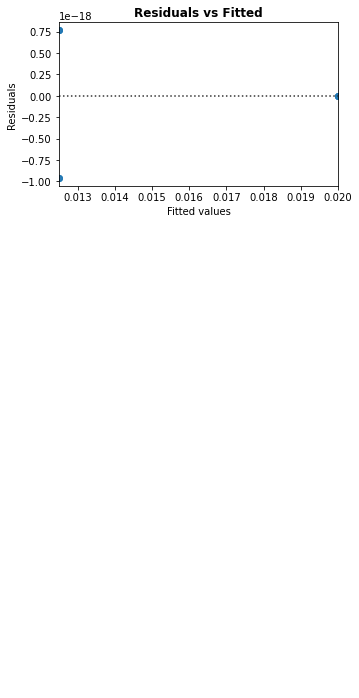

In [41]:
#residual plot
fig, ax = plt.subplots(figsize=(5,3))

sns.residplot(x=y_predict, y=residual, lowess=True,scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)

# annotations
residual_abs = np.abs(residual)
abs_resid = np.flip(np.sort(residual_abs))
abs_resid_top_3 = abs_resid[:3]
for i, _ in enumerate(abs_resid_top_3):
    ax.annotate(i, xy=(y_predict[i], residual[i]), color='C3')

ax.set_title('Residuals vs Fitted', fontweight="bold")
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')


plt.show()

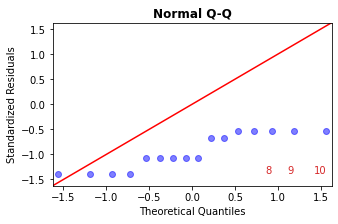

In [43]:
fig, ax = plt.subplots(figsize=(5,3))

QQ = ProbPlot(residual_norm)
QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
abs_norm_resid = np.flip(np.argsort(np.abs(residual_norm)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    ax.annotate(i,xy=(np.flip(QQ.theoretical_quantiles, 0)[r], residual_norm[i]),
                ha='right', color='C3')
    ax.set_title('Normal Q-Q', fontweight="bold")
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized Residuals')
    
plt.show()

In [44]:
vif_df = pd.DataFrame()
vif_df["Features"] = xvar_names
vif_df["VIF Factor"] = [variance_inflation_factor(xvar, i) for i in range(xvar.shape[1])]
print(vif_df.sort_values("VIF Factor").round(2))

C:\Users\lawis\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                      Features  VIF Factor
0                        const         0.0
1                     downwind         inf
2            avg_pm25_exposure         inf
3   months_over_pm25_threshold         inf
4              avg_temperature         inf
5          zip_code_population         inf
6       zip_code_avg_elevation         inf
7       zip_code_median_income         inf
8           pct_ethnic_group_1         inf
9              pct_age_group_1         inf
10                    pct_male         inf
11                  pct_female         inf


C:\Users\lawis\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


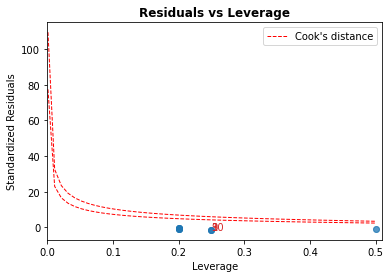

In [53]:
def cooks_dist_line(nparams, factor,leverage):
    p = nparams
    formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
    x = np.linspace(0.001, max(leverage), 50)
    y = formula(x)
    return x, y

fig, ax = plt.subplots()
ax.scatter(leverage,residual_norm, alpha=0.5);
sns.regplot(x=leverage, y=residual_norm, scatter=False, ci=False,lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax=ax)

# annotations
leverage_top_3 = np.flip(np.argsort(cooks_distance), 0)[:3]
for i in leverage_top_3:
    ax.annotate(i, xy=(leverage[i], residual_norm[i]),color = 'C3')

xtemp, ytemp = cooks_dist_line(nparams,0.5,leverage) # 0.5 line
ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
xtemp, ytemp = cooks_dist_line(nparams,1,leverage) # 1 line
ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

ax.set_xlim(0, max(leverage)+0.01)
ax.set_title('Residuals vs Leverage', fontweight="bold")
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')
ax.legend(loc='upper right')